# A short tutorial on USTC-Pickers ($\approx$3 min)
* If any question, please feel free to contact me via email: `zhujun2316@mail.ustc.edu.cn`
* Dependencies: Obspy, PyTorch, [SeisBench](https://github.com/seisbench/seisbench)

## Load a model

In [22]:
import seisbench
import seisbench.models as sbm

# Instatiate a picker
sample_rate = 50 # Our pickers are trained using waveform sampled at 50 Hz
picker = sbm.PhaseNet(phases='PSN', sampling_rate=sample_rate)
# print(picker) # Uncomment this line to see the structure of the PhaseNet model if necessary

In [18]:
import os
import glob
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from config import (en2cn, model_list)

# Specify your target region
location = input('Plase specify a region or province to pick phases, e.g. Beijing. 41 pickers are available now in the subfolder "%s"'%(os.path.join('USTC-Pickers', 'model_list', '')))
if location not in en2cn:
    raise UserWarning('The region you specified is not available. Please choose a region or province listed below:\n%s.'%(', '.join(['%s (%s)'%(x,y) for x,y in en2cn.items()])))
else:
    model_save_path = glob.glob(os.path.join(model_list, '*'+en2cn[location]+'.pt'))[0]
    print('You are using the picker located at %s'%model_save_path)
    # Load a picker suitable to your target region
    picker.load_state_dict(torch.load(model_save_path,
			map_location=device).state_dict())

Plase specify a region or province to pick phases, e.g. Beijing. 41 pickers are available now in the subfolder "USTC-Pickers/model_list/"Beijing
You are using the picker located at ../model_list/6_北京市.pt


## Read waveforms

In [19]:
from obspy import read
from config import (sac, mseed)

# Read the 3-component waveforms as input
print(sac)
#print(mseed)
stream = read(sac)
#stream = read(mseed)
print(stream)

../test_data/sac/Beijing*.sac
3 Trace(s) in Stream:
...BHE | 2018-07-18T15:24:11.300000Z - 2018-07-18T15:27:11.280000Z | 50.0 Hz, 9000 samples
...BHN | 2018-07-18T15:24:11.300000Z - 2018-07-18T15:27:11.280000Z | 50.0 Hz, 9000 samples
...BHZ | 2018-07-18T15:24:11.300000Z - 2018-07-18T15:27:11.280000Z | 50.0 Hz, 9000 samples


## Model response (optional)

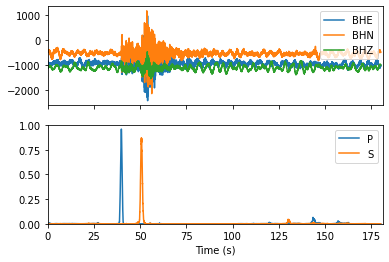

In [20]:
import numpy as np

# Calculate the response
response = picker.annotate(stream)

# Plot the response
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, sharex=True)
t = np.arange(stream[0].data.shape[0])/sample_rate
ax[0].plot(t, np.array([x.data for x in stream]).transpose(), label=[x.stats.channel for x in stream])
ax[1].plot(t, np.array([x.data for x in response[:-1]]).transpose(), label=['P', 'S'])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylim(0, 1)
for j in ax:
    j.legend()
    j.set_xlim(0, t.max()+1)
plt.show()
plt.close()

## Retrieve the predicted picks

In [21]:
picks = picker.classify(stream, P_threshold=.3, S_threshold=.3) # Both thresholds can be tuned for your target
for x in picks:
    print(x.__dict__, '\n', x.peak_time-x.start_time)

{'trace_id': '..', 'start_time': UTCDateTime(2018, 7, 18, 15, 24, 50, 480000), 'end_time': UTCDateTime(2018, 7, 18, 15, 24, 51, 840000), 'peak_time': UTCDateTime(2018, 7, 18, 15, 24, 51, 120000), 'peak_value': 0.958199, 'phase': 'P'} 
 0.64
{'trace_id': '..', 'start_time': UTCDateTime(2018, 7, 18, 15, 25, 1, 340000), 'end_time': UTCDateTime(2018, 7, 18, 15, 25, 2, 860000), 'peak_time': UTCDateTime(2018, 7, 18, 15, 25, 1, 940000), 'peak_value': 0.8697559, 'phase': 'S'} 
 0.6
